# CLASSIFYING TIKTOK VIDEOS USING MACHINE LEARNING
## Introduction
TikTok allows users to report videos that may violate its terms of service, leading to a high volume of reports, far too many for human moderators to handle individually. Our analysis indicates that videos violating terms are more likely to contain claims rather than opinions, making it crucial to distinguish between the two.

TikTok plans to develop a machine learning model to classify videos as either claims or opinions. Videos identified as opinions will have a lower priority for human review, while claim videos will be further processed to determine their review priority, possibly ranked by the number of reports they receive.

### 1.Targeting variable for the model
The model's target variable will be "claim_status," a binary indicator of whether a video is a claim or an opinion. This classification task will help moderators focus on the videos most likely to violate TikTok's terms of service.

### 2. Evaluation metric
In this scenario, it's more critical for the model to err on the side of false positives rather than false negatives. Identifying videos that violate the terms of service is paramount, even if some opinion videos are mistakenly flagged as claims. If an opinion is misclassified as a claim, the worst outcome is that it undergoes human review. However, if a claim is incorrectly classified as an opinion, it might not be reviewed at all, potentially allowing a violation to go unnoticed. Since minimizing false negatives is crucial, the model evaluation metric will focus on **recall**.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [5]:
# Loading dataset into dataframe
data = pd.read_csv("/Users/jiaqi.cui/Desktop/Fun datasets/tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### Column Name	Description
claim_status:	Indicates whether the video has been reported for containing a claim or opinion (e.g., 'Reported', 'Not Reported').

video_id:	Unique identifier for each video.

video_duration_sec:	Duration of the video in seconds.

video_transcription_text:	Transcription of the video's audio content.

verified_status:	Indicates whether the video creator's account is verified (e.g., 'Verified', 'Not Verified').

author_ban_status:	Indicates if the video's author has been banned (e.g., 'Banned', 'Not Banned').

video_view_count:	Total number of views the video has received.

video_like_count:	Total number of likes the video has received.

video_share_count:	Total number of times the video has been shared.

video_download_count:	Total number of times the video has been downloaded.

video_comment_count:	Total number of comments on the video.

In [7]:
# Exploratory Data Analysis
## Process:
### 1. Descriptive statistics
### 2. Missing data 
### 3. Outliers


In [8]:
# Getting basic information
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [9]:
# Generating basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [10]:
# Clean the dataset
data.drop('#', axis=1, inplace=True)

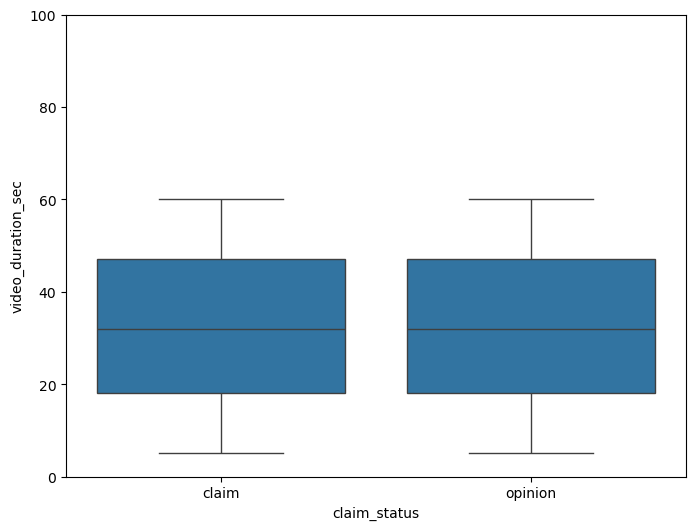

In [11]:
#box plot
var = 'video_duration_sec'
data_plot = pd.concat([data['claim_status'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="claim_status", y=var, data=data_plot)
fig.axis(ymin=0, ymax=100);

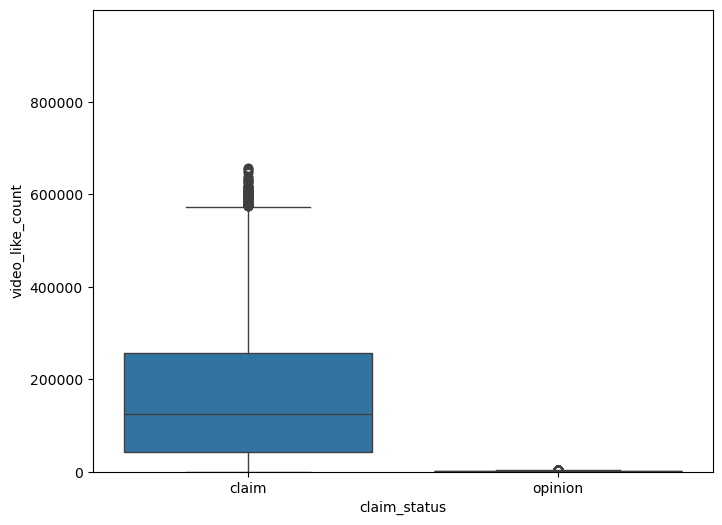

In [12]:
#box plot
var = 'video_like_count'
data_plot = pd.concat([data['claim_status'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="claim_status", y=var, data=data_plot)
fig.axis(ymin=0, ymax=999817);

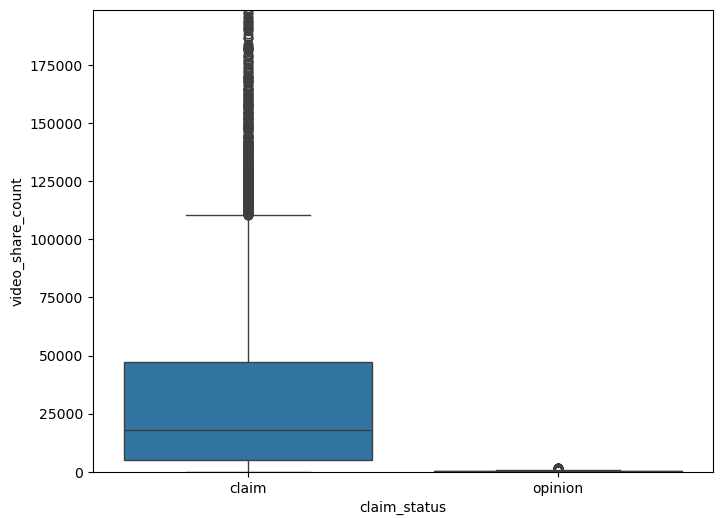

In [13]:
#box plot
var = 'video_share_count'
data_plot = pd.concat([data['claim_status'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="claim_status", y=var, data=data_plot)
fig.axis(ymin=0, ymax=199000);

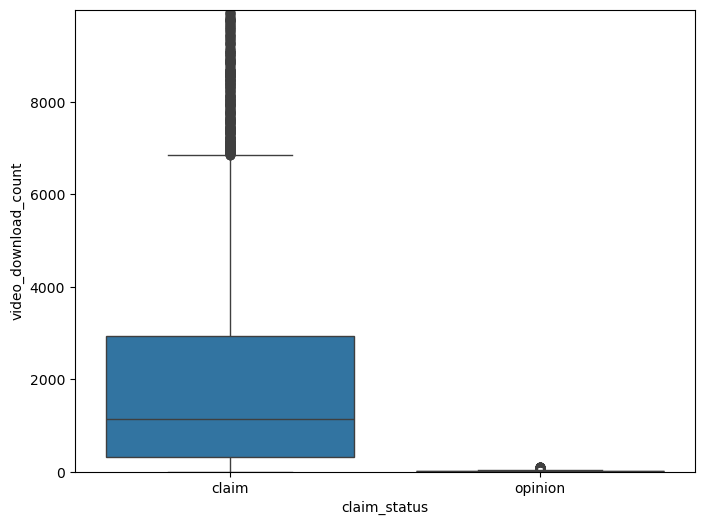

In [14]:
#box plot
var = 'video_download_count'
data_plot = pd.concat([data['claim_status'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="claim_status", y=var, data=data_plot)
fig.axis(ymin=0, ymax=9999);

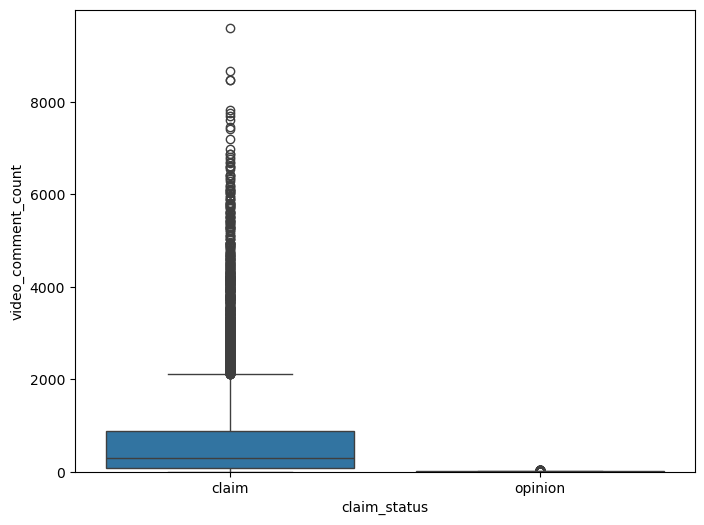

In [15]:
#box plot
var = 'video_comment_count'
data_plot = pd.concat([data['claim_status'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="claim_status", y=var, data=data_plot)
fig.axis(ymin=0, ymax=9999);

# Summary of features' box plots
* It looks like 'video_duration_sec' doesn't seem to be related to video's 'claim_status'
* 'video_like_count', 'video_share_count', 'video_download_count' and 'video_comment_count' seem to be related with 'claim_status'

# 2. Missing data

Important questions about missing data:

* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.


In [18]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
claim_status,298,0.015375
video_transcription_text,298,0.015375
video_view_count,298,0.015375
video_like_count,298,0.015375
video_share_count,298,0.015375
video_download_count,298,0.015375
video_comment_count,298,0.015375
video_id,0,0.000000
video_duration_sec,0,0.000000
verified_status,0,0.000000


In [19]:
#dealing with missing data
# Dropping rows with missing values
data = data.dropna(axis=0)

# 3. Checking class balance

In [21]:
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced. Additionally, Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

# 4. Correlation matrix

In [24]:
data.columns.values.tolist()

['claim_status',
 'video_id',
 'video_duration_sec',
 'video_transcription_text',
 'verified_status',
 'author_ban_status',
 'video_view_count',
 'video_like_count',
 'video_share_count',
 'video_download_count',
 'video_comment_count']

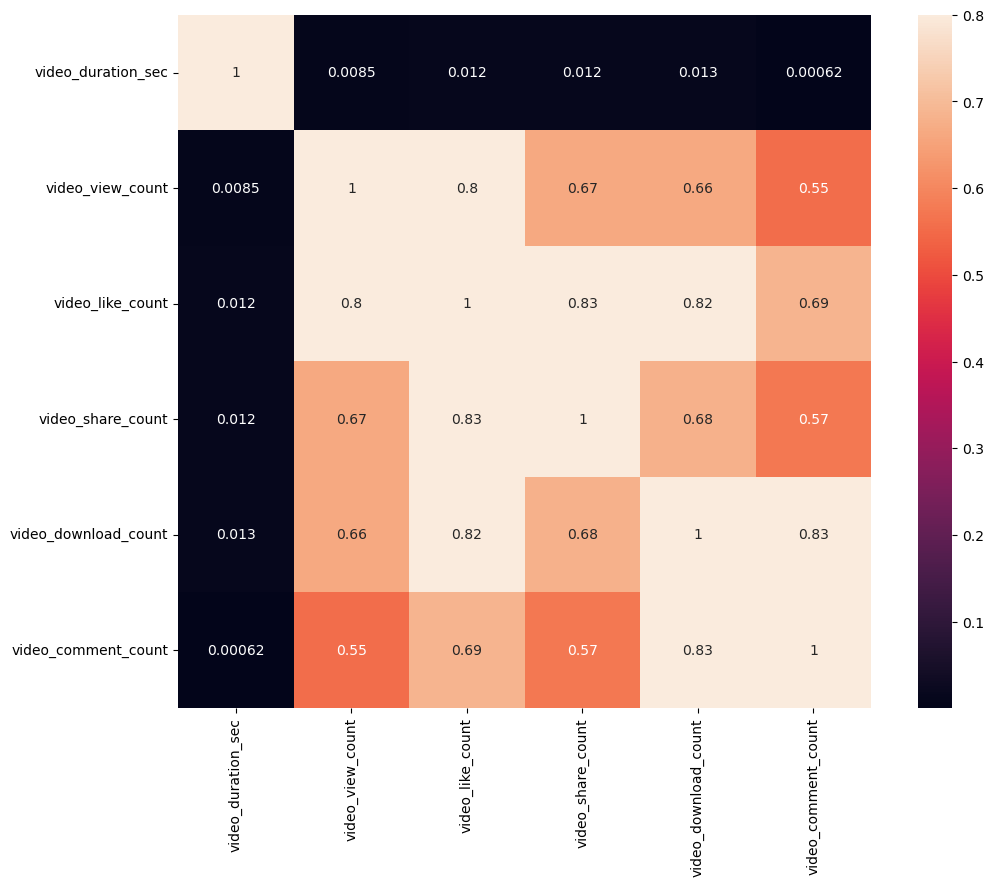

In [25]:
#correlation matrix
corrmat = data[['video_duration_sec',
 'video_view_count',
 'video_like_count',
 'video_share_count',
 'video_download_count',
 'video_comment_count']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,  cbar=True, annot=True);

# Feature engineering

In [27]:
# Creating `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [28]:
# Now lets calculate the average text_length for claims and opinions.
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


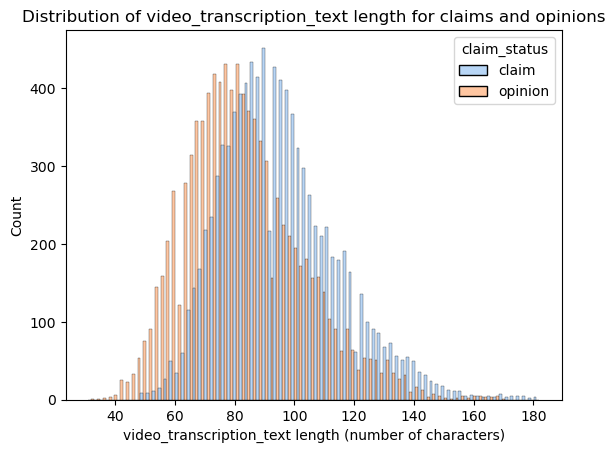

In [29]:
# Visualising the distribution of `text_length` for claims and opinions
# Creating two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters—about 13 more on average, as indicated in a previous cell.

# Feature selection

In [32]:
# Create a copy of the data and drop unnecessary columns
X = data.drop(columns=['video_id'])

# Encode the target variable 'claim_status'
X['claim_status'] = X['claim_status'].map({'opinion': 0, 'claim': 1})

# Dummy encode categorical variables
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)

# Display the first few rows of the modified DataFrame
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


# Splitting data

In [34]:
# Isolating target variable
y = X['claim_status']
# Isolating features
X = X.drop(['claim_status'], axis=1)
# Displaying first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [35]:
# Splitting the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [37]:
# Getting shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

# Tokenizing text column

In [39]:
import nltk
from nltk import ngrams
from collections import Counter
from collections import Counter
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaqi.cui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiaqi.cui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
X_train['video_transcription_text']

14829    my family's opinion is that the total number o...
7396     a friend read a study mentioning that bubble w...
2287     a friend read  online that the longest recorde...
18712    my family is convinced  that it snows in the s...
9931     i feel that halley’s comet won’t be seen again...
                               ...                        
18043    my family is willing to wager that canada has ...
11462    my thinking is that vinyl record sales now sur...
6819     a colleague read  in the media that the total ...
11795    my feeling is that it would take 258 earth day...
4092     someone read  in a discussion board that lemur...
Name: video_transcription_text, Length: 11450, dtype: object

In [41]:
# Parameters
ngram_range = (2, 3)
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to tokenize, remove stop words, and generate n-grams
def tokenize_and_ngrams(text, ngram_range=(1, 1), stop_words=None):
    tokens = nltk.word_tokenize(text.lower())
    if stop_words:
        tokens = [word for word in tokens if word not in stop_words]
    
    ngrams_list = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list.extend(ngrams(tokens, n))
    
    return ngrams_list

# Extract n-grams for all documents in X_train
all_ngrams = []
for text in X_train['video_transcription_text']:
    all_ngrams.extend(tokenize_and_ngrams(text, ngram_range, stop_words))

# Count frequencies of all n-grams
ngram_counts = Counter(all_ngrams)

# Select the top n-grams based on frequency (mimicking max_features)
top_ngrams = [ngram for ngram, _ in ngram_counts.most_common(15)]  # max_features=15

# Function to transform a single text into a count vector based on top n-grams
def text_to_vector(text, top_ngrams, ngram_range=(1, 1), stop_words=None):
    tokens = tokenize_and_ngrams(text, ngram_range, stop_words)
    vector = np.zeros(len(top_ngrams))
    
    for i, ngram in enumerate(top_ngrams):
        vector[i] = tokens.count(ngram)
    
    return vector

# Transform all texts in X_train into numerical feature vectors
count_data = np.array([text_to_vector(text, top_ngrams, ngram_range, stop_words)
                       for text in X_train['video_transcription_text']])

# Display the result
count_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
# Convert n-grams to string format for column names
ngram_names = [' '.join(ngram) for ngram in top_ngrams]

# Create the DataFrame
count_df = pd.DataFrame(data=count_data, columns=ngram_names)

# Display the first few rows of the DataFrame
count_df.head()

,family 's,friends ',colleagues ',media claim,friend read,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Concatenating `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Displaying first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Extracting numerical features from `video_transcription_text` in the val set
count_val_data = np.array([text_to_vector(text, top_ngrams, ngram_range, stop_words)
                       for text in X_val['video_transcription_text']])

# Create the DataFrame
count_val_df = pd.DataFrame(data=count_val_data, columns=ngram_names)

# Display the first few rows of the DataFrame
count_val_df.head()

,family 's,friends ',colleagues ',media claim,friend read,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), count_val_df], axis=1)

# Displaying first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now, we repeat the process to get n-gram counts for the test data. Again, don't refit the vectorizer to the test data. Just transform it.

In [47]:
# Extracting numerical features from `video_transcription_text` in the val set
count_test_data = np.array([text_to_vector(text, top_ngrams, ngram_range, stop_words)
                       for text in X_test['video_transcription_text']])

# Create the DataFrame
count_test_df = pd.DataFrame(data=count_test_data, columns=ngram_names)

# Display the first few rows of the DataFrame
count_test_df.head()

,family 's,friends ',colleagues ',media claim,friend read,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# so that the indices align with those in `validation_count_df`
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), count_test_df], axis=1)

# Displaying first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,someone read,colleague read,friend learned,colleague learned,internet forum,someone discovered,discussion board,someone learned,read media,learned media
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

## Randome forest classifier

First, we fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall

In [52]:
# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Defining a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1': 'f1',
    'recall': 'recall'
}

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [53]:
rf_cv.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [54]:
# Examining best recall score
rf_cv.best_score_

0.9953405130085043

# XGBoost classifier

In [56]:
# Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Defining a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1': 'f1',
    'recall': 'recall'
}

# Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [57]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 2min 44s, sys: 1min 1s, total: 3min 46s
Wall time: 20.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [58]:
xgb_cv.best_score_

0.9899901797303077

In [59]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

# Model Evaluation: Random Forest

In [61]:
# Using the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

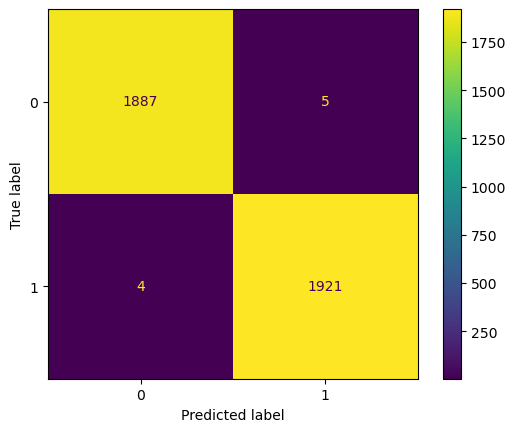

In [62]:
# Creating a confusion matrix to visualise the results of the classification model

# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.show()

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

In [65]:
# Creating a classification report
# Creating classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



# Model Evaluation: XGBoost model


In [67]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

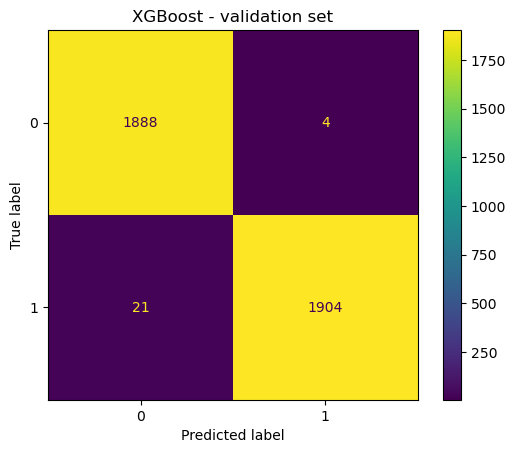

In [68]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('XGBoost - validation set');
plt.show()

In [69]:
# Creating a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [70]:
# Using champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

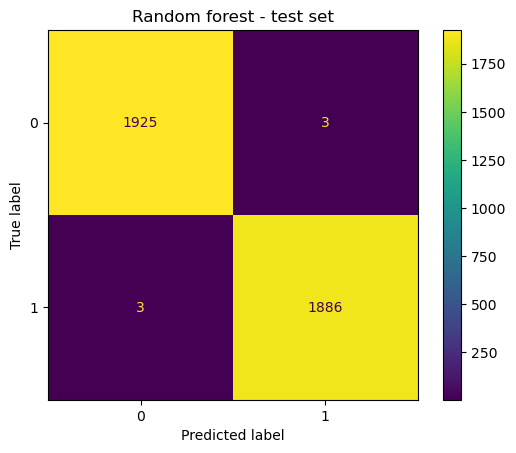

In [71]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('Random forest - test set');
plt.show()

In [72]:
# Feature importance

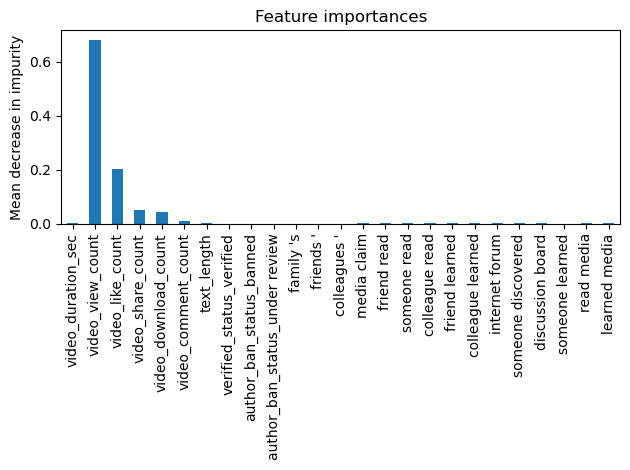

In [73]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()